##### TITANIC数据集的预处理

In [64]:
#导包
import argparse
from math import sqrt
import os.path
import torch.cpu
from sklearn.metrics import roc_auc_score
import copy
from torch.utils.tensorboard import SummaryWriter
from thop import clever_format, profile
from torchsummary import summary
import torch
import torch.nn as nn
import os
import time
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import seaborn as sns  
import warnings
import csv

In [65]:
#对训练集进行处理
train = pd.read_csv('train.csv')
train.info() # 查看train.csv的总体信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


可以看到训练集总共有891条数据，其中特征数量为9个，还有一个生存的标签
其中name,age,ticket、cabin、Embarked为文本数据
特征代表的意义如下：
-  PassengerId:乘客ID
-  Survived: 标签（0代表死亡，1代表存活）
-  Pclass：乘客所持票的类别
-  Name：乘客姓名（删除）
-  Sex：性别
-  Age：乘客年龄（有缺失）
-  SibSp：在船上的兄弟姐妹人数
-  Parch ：在船上的父母/小孩人数
-  Ticket：船票信息（舍去）
-  Fare：票价
-  Cabin：客舱（缺失数据量大，舍去）
-  Embarked：登船港口（S、C、Q）

In [66]:
#查看缺失数据
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [67]:
#缺失值处理
print('Percent of missing "Cabin" records is %.2f%%' %((train['Age'].isnull().sum()/train.shape[0])*100))

Percent of missing "Cabin" records is 19.87%


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

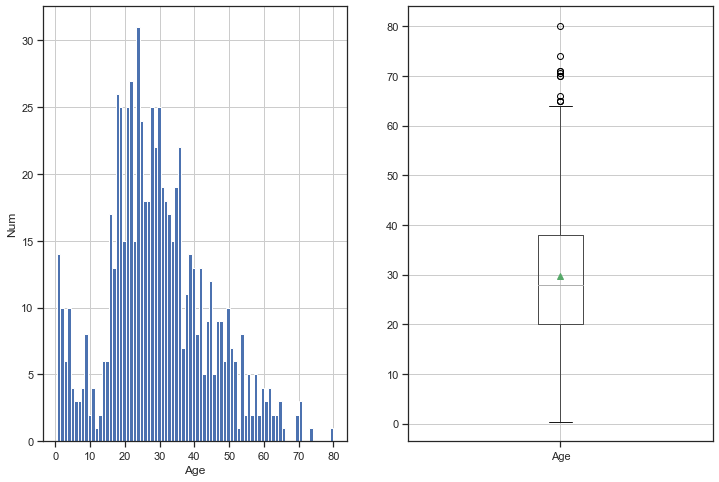

In [68]:
sns.set()
sns.set_style('ticks')

# 缺失值处理：年龄Age字段
train_age=train[train['Age'].notnull()]

# 年龄数据的分布情况
plt.figure(figsize=(12,8))

plt.subplot(121)
train_age['Age'].hist(bins=80)
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(122)
train_age.boxplot(column='Age',showfliers=True,showmeans=True)

train_age['Age'].describe()

In [69]:
# 要对缺失值处理，使用平均值填充
train['Age']=train['Age'].fillna(train['Age'].mean())
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [70]:
#缺失值处理-Cabin
print('Percent of missing "Cabin" records is %.2f%%' %((train['Cabin'].isnull().sum()/train.shape[0])*100))

Percent of missing "Cabin" records is 77.10%


In [71]:
#缺失值占比太高，删除
train.drop(['Cabin'],axis=1,inplace=True) # 删去Cabin的那一列数据

In [72]:
#缺失值处理-Embarked
print('Percent of missing "Embarked" records is %.2f%%' %((train['Embarked'].isnull().sum()/train.shape[0])*100))

Percent of missing "Embarked" records is 0.22%


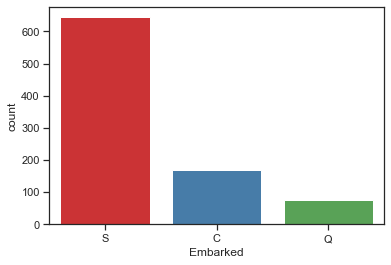

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [73]:
#数据分布情况
sns.countplot(x='Embarked',data=train,palette='Set1')
plt.show()
train['Embarked'].value_counts()

In [74]:
#缺失值使用占比最多的值填充
train.Embarked = train.Embarked.fillna('S')

In [75]:
#处理后的数据
train['Age']=train['Age'].fillna(train['Age'].mean()) # 用平均值填充
# train.drop(['Cabin'],axis=1,inplace=True) # 删去Cabin的那一列数据
train.Embarked = train.Embarked.fillna('S') # 用’S'填补缺失值
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


<AxesSubplot:ylabel='Survived'>

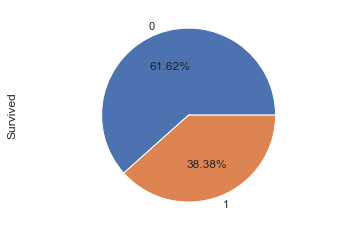

In [76]:
#存活情况的分析
train_survived=train[train['Survived'].notnull()]

# 用seaborn绘制饼图，分析已知存活数据中的存活比例
sns.set_style('ticks') # 十字叉
plt.axis('equal')       #行宽相同
train_survived['Survived'].value_counts().plot.pie(autopct='%1.2f%%')

女性存活率74.20%,男性存活率18.89%


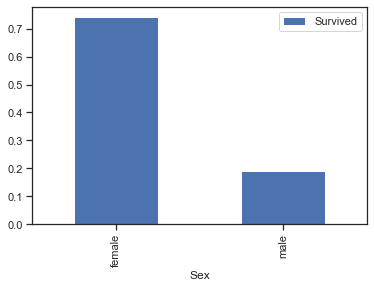

In [77]:
#不同性别存活情况分布的分析
# 男性和女性存活情况
train[['Sex','Survived']].groupby('Sex').mean().plot.bar()

survive_sex=train.groupby(['Sex','Survived'])['Survived'].count()

print('女性存活率%.2f%%,男性存活率%.2f%%' %
     (survive_sex.loc['female',1]/survive_sex.loc['female'].sum()*100,
      survive_sex.loc['male',1]/survive_sex.loc['male'].sum()*100)
     )

Sex       female  male
Survived              
0             81   468
1            233   109


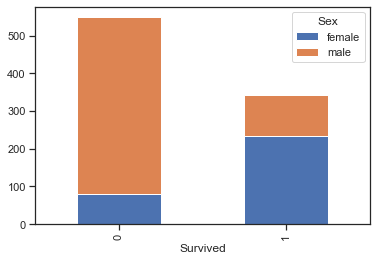

In [78]:
#性别与存活的关联
# 查看survived 与 Sex的关系
Survived_Sex = train['Sex'].groupby(train['Survived'])
print(Survived_Sex.value_counts().unstack())

Survived_Sex.value_counts().unstack().plot(kind = 'bar', stacked = True)
plt.show()

D:\chj\ipykernel_12628\1846945374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_age['Age']=train_age['Age'].astype(np.int)


<AxesSubplot:xlabel='Age', ylabel='Survived'>

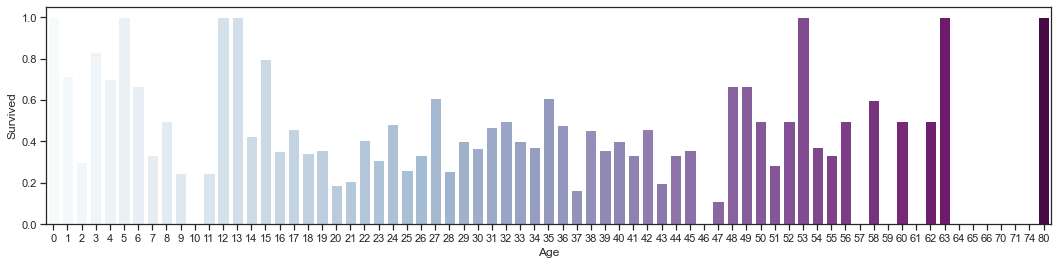

In [79]:
#对年龄的分析
plt.figure(figsize=(18,4))
train_age['Age']=train_age['Age'].astype(np.int)
average_age=train_age[['Age','Survived']].groupby('Age',as_index=False).mean()
# print(average_age)
sns.barplot(x='Age',y='Survived',data=average_age,palette='BuPu')

<AxesSubplot:xlabel='family_size'>

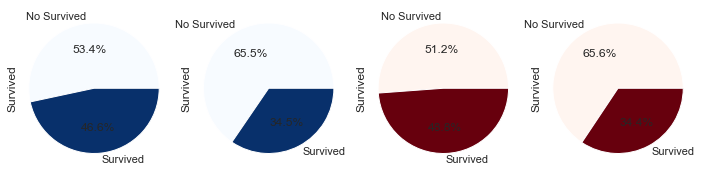

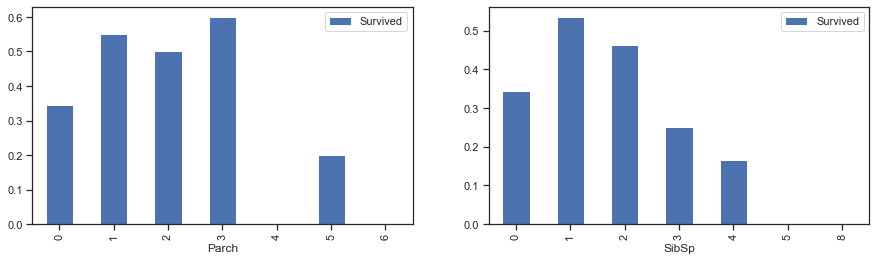

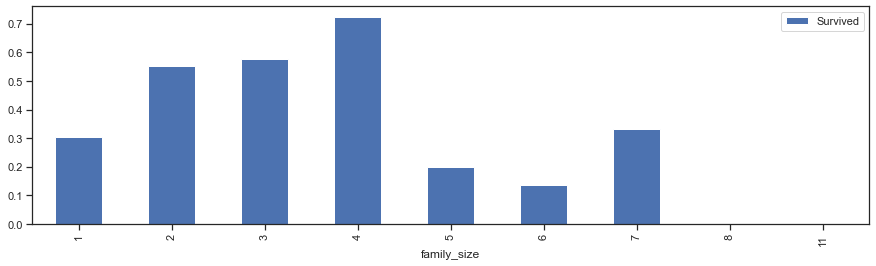

In [80]:
# 筛选出有无兄弟姐妹
sibsp_df = train[train['SibSp']!=0] # 有兄弟姐妹
no_sibsp_df = train[train['SibSp']==0] # 没有兄弟姐妹

# 筛选处有无父母子女
parch_df = train[train['Parch']!=0] # 有父母子女
no_parch_df = train[train['Parch']==0] # 没有父母

plt.figure(figsize=(12,3))
plt.subplot(141)
plt.axis('equal')
sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct='%1.1f%%',colormap='Blues')

plt.subplot(142)
plt.axis('equal')
no_sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct='%1.1f%%',colormap='Blues')


plt.subplot(143)
plt.axis('equal')
parch_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct='%1.1f%%',colormap='Reds')

plt.subplot(144)
plt.axis('equal')
no_parch_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct='%1.1f%%',colormap='Reds')
     

# 亲戚多少与是否存活有关吗？
fig,ax=plt.subplots(1,2,figsize=(15,4))
train[['Parch','Survived']].groupby('Parch').mean().plot.bar(ax=ax[0])
train[['SibSp','Survived']].groupby('SibSp').mean().plot.bar(ax=ax[1])

train['family_size']=train['Parch']+train['SibSp']+1
train[['family_size','Survived']].groupby('family_size').mean().plot.bar(figsize=(15,4))


<AxesSubplot:xlabel='Pclass'>

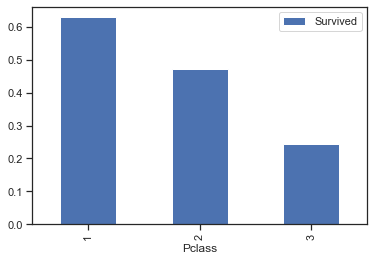

In [81]:
train[['Pclass','Survived']].groupby('Pclass').mean().plot.bar()

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119


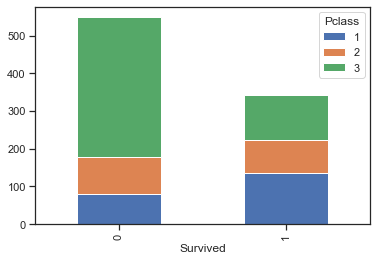

In [82]:
# 查看Survived 与 Pclass的关系
Survived_Pclass = train['Pclass'].groupby(train['Survived'])
print(Survived_Pclass.value_counts().unstack())

Survived_Pclass.value_counts().unstack().plot(kind = 'bar', stacked = True)
plt.show()

<AxesSubplot:>

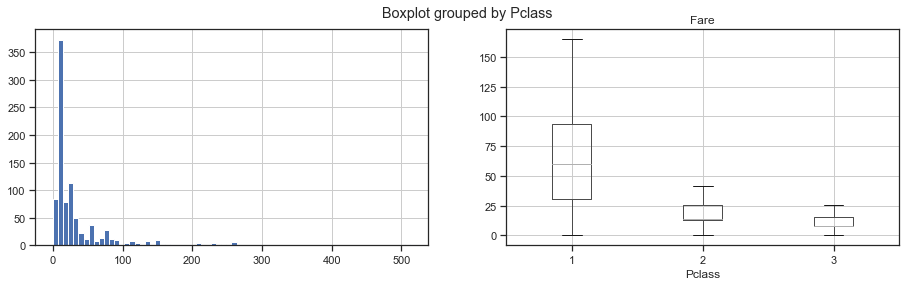

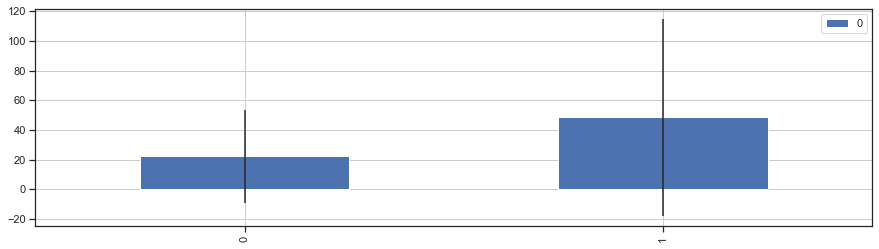

In [83]:
fig,ax=plt.subplots(1,2,figsize=(15,4))
train['Fare'].hist(bins=70,ax=ax[0])
train.boxplot(column='Fare',by='Pclass',showfliers=False,ax=ax[1])

fare_not_survived=train['Fare'][train['Survived']==0]
fare_survived=train['Fare'][train['Survived']==1]
# 筛选数据

average_fare=pd.DataFrame([fare_not_survived.mean(),fare_survived.mean()])
std_fare=pd.DataFrame([fare_not_survived.std(),fare_survived.std()])

average_fare.plot(yerr=std_fare,kind='bar',figsize=(15,4),grid=True)

D:\chj\ipykernel_12628\1548781457.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True,which='major',axis='y')


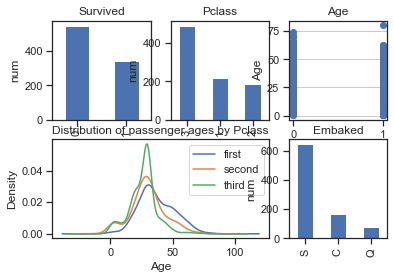

In [84]:
fig=plt.figure()
fig.set(alpha=0.2)

plt.subplot2grid((2,3),(0,0))
train.Survived.value_counts().plot(kind='bar')
plt.title('Survived')
plt.ylabel('num')

plt.subplot2grid((2,3),(0,1))
train.Pclass.value_counts().plot(kind='bar')
plt.title('Pclass')
plt.ylabel('num')

plt.subplot2grid((2,3),(0,2))
plt.scatter(train.Survived,train.Age)
plt.ylabel('Age')
plt.grid(b=True,which='major',axis='y')
plt.title('Age')

plt.subplot2grid((2,3),(1,0),colspan=2)
train.Age[train.Pclass == 1].plot(kind='kde')
train.Age[train.Pclass == 2].plot(kind='kde')
train.Age[train.Pclass == 3].plot(kind='kde')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of passenger ages by Pclass')
plt.legend(('first','second','third'),loc='best')

plt.subplot2grid((2,3),(1,2))
train.Embarked.value_counts().plot(kind='bar')
plt.title('Embaked')
plt.ylabel('num')
plt.show()

In [85]:
dataset=train

In [86]:
#对Sex编码
sexdict = {'male':1, 'female':0}
dataset.Sex = dataset.Sex.map(sexdict)


In [87]:
#将Embarked, Cabin, Pclass进行one_hot编码
embarked2 = pd.get_dummies(dataset.Embarked, prefix = 'Embarked')

dataset = pd.concat([dataset,embarked2], axis = 1) ## 将编码好的数据添加到原数据上
dataset.drop(['Embarked'], axis = 1, inplace=True) ## 过河拆桥

dataset.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,family_size,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.25,2,0,0,1


In [88]:
#建立family_size特征
dataset['family']=dataset.SibSp+dataset.Parch+1

dataset.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,family_size,Embarked_C,Embarked_Q,Embarked_S,family
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.25,2,0,0,1,2


In [89]:
dataset.drop(['Name'],axis=1, inplace=True)
dataset.drop(['Ticket'], axis=1, inplace=True)
# dataset.drop(['Cabin'],  inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   family_size  891 non-null    int64  
 9   Embarked_C   891 non-null    uint8  
 10  Embarked_Q   891 non-null    uint8  
 11  Embarked_S   891 non-null    uint8  
 12  family       891 non-null    int64  
dtypes: float64(2), int64(8), uint8(3)
memory usage: 72.3 KB


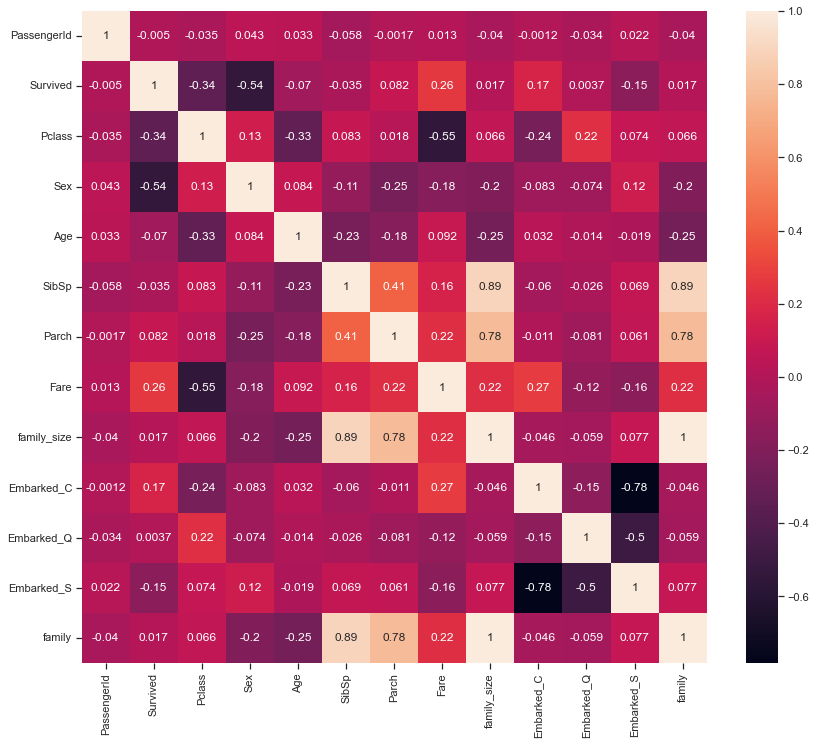

In [90]:
plt.figure(figsize=(14,12))
sns.heatmap(dataset.corr(),annot = True)
plt.show()

In [91]:
type(dataset)
#表头
column=['PassengerId','Survived','Pclass','Sex','Age','SibSp','Parch','Fare','family_size','Embarked_C','Embarked_Q','Embarked_S','family'] 

In [92]:
dataset1=pd.DataFrame(columns=column,data=dataset)
dataset1.to_csv('train_chuli.csv')